# loading trainging and testing dataset

In [39]:
#install packages
using Pkg
haskey(Pkg.installed(),"Knet") || Pkg.add("Knet")
haskey(Pkg.installed(),"CodecZlib") || Pkg.add("CodecZlib")
haskey(Pkg.installed(),"Images") || Pkg.add("Images")
haskey(Pkg.installed(), "Colors") || Pkg.add("Colors")
haskey(Pkg.installed(), "Statistics") || Pkg.add("Statistics")
haskey(Pkg.installed(), "Random") || Pkg.add("Random")
using Knet
using CodecZlib
using Plots, Statistics, LinearAlgebra, Random
using Images, ImageIO, QuartzImageIO, ImageMagick, Colors

In [40]:
# the data will be imported from "http://yann.lecun.com/exdb/mnist"
mnsitUrl = "http://yann.lecun.com/exdb/mnist"
mnsitDir = "./Data"
xtrn_file, ytrn_file, xtst_file, ytst_file = 
    "train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz", "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"


#download the traing and testing files
function _mnsit_download_data(file)
    println("downloading $file")
    if(!isdir(mnsitDir))
        mkpath(mnsitDir)
    end
    filePath = joinpath(mnsitDir, file)
    if(!isfile(filePath))
        url = string(mnsitUrl, "/", file)
        println(url)
        download(url, filePath)
    end
    
    #each images x file conatins the images represented as 784 pixels, which are normalized to [0-1] float numbers
    #each label y is represented as a single number which represents the correct digit. 10 is used to represnt 0
    f = GzipDecompressorStream(open(filePath))
    a = read(f)
    close(f)
    return(a)
end


function _mnsit_load_data()
    global xtrn, ytrn, xtst, ytst
    xtrn, ytrn, xtst, ytst = _mnsit_download_data.([xtrn_file, ytrn_file, xtst_file, ytst_file])
    #reshape y data to an array of dimantions 28*28*1*N, where N is the number of samples
    _x_reshape(x) = reshape(x[17:end] ./ 255f0, (28,28,1,(length(x)÷(28*28))))
    xtrn, xtst = _x_reshape.([xtrn, xtst])
    println(length(ytrn), " " , length(ytst))
    _y_reshape(y) = (Int.(y);(y[y.==0] .= 10); y[9:end])
    ytrn, ytst = _y_reshape.([ytrn, ytst])
    println(length(ytrn), " " , length(ytst))
end

_mnsit_load_data()

downloading train-images-idx3-ubyte.gz
downloading train-labels-idx1-ubyte.gz
downloading t10k-images-idx3-ubyte.gz
downloading t10k-labels-idx1-ubyte.gz
60008 10008
60000 10000


# Show couple of samples from the training set

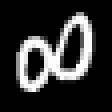

The correct digit is: 8


In [41]:
ind = rand(1:size(xtrn, 4))
img = xtrn[:,:,1,ind]
println("The correct digit is: ", ytrn[ind])
Image = Gray.(img)
display(Image)

# Preparing the data and essential functions

In [42]:
#converting y data to one hot represntation
function one_hot(y)
    tmp = zeros(10,length(y))
    for i in 1:length(y)
        tmp[y[i], i] = 1
    end
    return tmp
end
ytrn, ytst = one_hot.([ytrn, ytst])
#converting x data into 784*N matrix
xtrn = Array{Float32}(mat(xtrn))
xtst = Array{Float32}(mat(xtst))
nothing

In [43]:
println.(summary.((xtrn, ytrn, xtst, ytst)))
#divid the data into minibatches
dtrn = minibatch(xtrn,ytrn,100)
dtst = minibatch(xtst,ytst,100)
#define accuracy
function accuracy(w, data)
    mean = 0
    for (x,y) in data
        for i in size(y, 2)
            mean += argmax(w*x[:,i]) == argmax(y[:,i])
        end
    end
    return mean/length(data)
end
#define W, our predection parameters
w = rand(Float32, (10, 784))
#accuracy test with random parameters
accuracy(w, dtst)

784×60000 Array{Float32,2}
10×60000 Array{Float64,2}
784×10000 Array{Float32,2}
10×10000 Array{Float64,2}


0.17

# Large VS Small batch-size training function

In [44]:
#trainging using large batch size (100)
function train(f, data, iter)
    w = rand(Float32, (10, 784))
    println(length(data))
    for i in 1:iter
        for (x,y) in data
            f(w,x,y)
        end
        println("iteration $i has an accuracy in the dtst of $(accuracy(w,dtst))", " ", norm(w))
        println("iteration $i has an accuracy in the dtrn of $(accuracy(w,dtrn))", " ", norm(w))
        end
    end
    return w
end

LoadError: syntax: unexpected "end"

In [45]:
#trainging using small batch size (1)
function train(f, xtrn::Array, ytrn::Array, iter)
    w = rand(Float32, (10, 784))
    for i in 1:(1<<iter)
        last = rand(1:size(xtrn,2))
        xx,yy = xtrn[:,last:last], ytrn[:,last:last]
        f(w,xx,yy)
        if log2(i) ≈ round(log2(i))
            println("iteration $i has an accuracy in the dtst of $(accuracy(w,dtst))", " ", norm(w))
            println("iteration $i has an accuracy in the dtrn of $(accuracy(w,dtrn))", " ", norm(w))
        end
    end
    println("iteration (1<<iter) has an accuracy in the dtst of $(accuracy(w,dtst))", " ", norm(w))
    println("iteration (1<<iter) has an accuracy in the dtrn of $(accuracy(w,dtrn))", " ", norm(w))
    return w
end
#=note that will larger batch size we achieve higher accuracy on the training dataset, but lower accurcy in the testing
dataset, and vica versa with lower batch size=#

train (generic function with 2 methods)

# One Layer Perceptron

In [46]:
function perceptron(w,x,y)
    pred = w*x
    for i in size(y,2)
        guess = argmax(pred[:,i])
        class = argmax(y[:,i])
        if guess != class
            w[guess,:] -= x[:,i]
            w[class,:] += x[:,i]
        end
    end
end

perceptron (generic function with 1 method)

In [47]:
println("One layer Perceptron with batch size of 100")
wperceptron_1 = train(perceptron, xtrn, ytrn, 20)
println("One layer Perceptron with batch size of 1")
wperceptron_100 = train(perceptron, dtrn, 100)

One layer Perceptron with batch size of 100
iteration 1 has an accuracy in the dtst of 0.05 51.296436
iteration 1 has an accuracy in the dtrn of 0.07166666666666667 51.296436
iteration 2 has an accuracy in the dtst of 0.13 52.703884
iteration 2 has an accuracy in the dtrn of 0.10666666666666667 52.703884
iteration 4 has an accuracy in the dtst of 0.13 53.909817
iteration 4 has an accuracy in the dtrn of 0.09333333333333334 53.909817
iteration 8 has an accuracy in the dtst of 0.12 56.78446
iteration 8 has an accuracy in the dtrn of 0.09833333333333333 56.78446
iteration 16 has an accuracy in the dtst of 0.2 62.41667
iteration 16 has an accuracy in the dtrn of 0.13833333333333334 62.41667
iteration 32 has an accuracy in the dtst of 0.26 73.34317
iteration 32 has an accuracy in the dtrn of 0.2916666666666667 73.34317
iteration 64 has an accuracy in the dtst of 0.52 88.03698
iteration 64 has an accuracy in the dtrn of 0.3983333333333333 88.03698
iteration 128 has an accuracy in the dtst of

iteration 44 has an accuracy in the dtst of 0.78 301.78217
iteration 44 has an accuracy in the dtrn of 1.0 301.78217
iteration 45 has an accuracy in the dtst of 0.78 301.78217
iteration 45 has an accuracy in the dtrn of 1.0 301.78217
iteration 46 has an accuracy in the dtst of 0.78 301.78217
iteration 46 has an accuracy in the dtrn of 1.0 301.78217
iteration 47 has an accuracy in the dtst of 0.78 301.78217
iteration 47 has an accuracy in the dtrn of 1.0 301.78217
iteration 48 has an accuracy in the dtst of 0.78 301.78217
iteration 48 has an accuracy in the dtrn of 1.0 301.78217
iteration 49 has an accuracy in the dtst of 0.78 301.78217
iteration 49 has an accuracy in the dtrn of 1.0 301.78217
iteration 50 has an accuracy in the dtst of 0.78 301.78217
iteration 50 has an accuracy in the dtrn of 1.0 301.78217
iteration 51 has an accuracy in the dtst of 0.78 301.78217
iteration 51 has an accuracy in the dtrn of 1.0 301.78217
iteration 52 has an accuracy in the dtst of 0.78 301.78217
itera

# Adaline

In [48]:
function adaline(w, x, y; lr = 1e-4)
    err = w * x - y
    w .-= lr * err * x'
end

adaline (generic function with 1 method)

In [49]:
println("Adaline with batch size of 100")
wAdaline_1 = train(adaline, xtrn, ytrn, 20)
println("Adaline with batch size of 1")
wAdaline_100 = train(adaline, dtrn, 100)

Adaline with batch size of 100
iteration 1 has an accuracy in the dtst of 0.06 51.20988
iteration 1 has an accuracy in the dtrn of 0.09666666666666666 51.20988
iteration 2 has an accuracy in the dtst of 0.06 51.178806
iteration 2 has an accuracy in the dtrn of 0.09666666666666666 51.178806
iteration 4 has an accuracy in the dtst of 0.06 50.9792
iteration 4 has an accuracy in the dtrn of 0.09666666666666666 50.9792
iteration 8 has an accuracy in the dtst of 0.05 50.772324
iteration 8 has an accuracy in the dtrn of 0.09833333333333333 50.772324
iteration 16 has an accuracy in the dtst of 0.06 50.411865
iteration 16 has an accuracy in the dtrn of 0.1 50.411865
iteration 32 has an accuracy in the dtst of 0.06 49.636353
iteration 32 has an accuracy in the dtrn of 0.10166666666666667 49.636353
iteration 64 has an accuracy in the dtst of 0.06 48.28393
iteration 64 has an accuracy in the dtrn of 0.10333333333333333 48.28393
iteration 128 has an accuracy in the dtst of 0.06 46.380688
iteration 

iteration 43 has an accuracy in the dtst of 0.84 27.95424
iteration 43 has an accuracy in the dtrn of 0.84 27.95424
iteration 44 has an accuracy in the dtst of 0.84 27.897715
iteration 44 has an accuracy in the dtrn of 0.8433333333333334 27.897715
iteration 45 has an accuracy in the dtst of 0.84 27.84263
iteration 45 has an accuracy in the dtrn of 0.8433333333333334 27.84263
iteration 46 has an accuracy in the dtst of 0.84 27.788918
iteration 46 has an accuracy in the dtrn of 0.8466666666666667 27.788918
iteration 47 has an accuracy in the dtst of 0.84 27.736519
iteration 47 has an accuracy in the dtrn of 0.8483333333333334 27.736519
iteration 48 has an accuracy in the dtst of 0.84 27.685375
iteration 48 has an accuracy in the dtrn of 0.85 27.685375
iteration 49 has an accuracy in the dtst of 0.84 27.635431
iteration 49 has an accuracy in the dtrn of 0.8533333333333334 27.635431
iteration 50 has an accuracy in the dtst of 0.84 27.586636
iteration 50 has an accuracy in the dtrn of 0.855

In [50]:
function softMax(w, x, y, lr = 0.000001)
    probs = exp.(w*x)
    println(summary(probs))
    probs ./= sum(probs)
    err = props - y
    w .-= lr * err * x'
end

softMax (generic function with 2 methods)

In [51]:
println("SoftMax with batch size of 100")
wSoftmax_1 = train(softMax, xtrn, ytrn, 20)
println("SoftMax with batch size of 1")
wSoftmax_100 = train(softMax, dtrn, 100)

SoftMax with batch size of 100
10×1 Array{Float32,2}


UndefVarError: UndefVarError: props not defined

# Gradient descent

In [52]:
#optemize with an array data set
#define argmax and max for Knet types
Base.argmax(a::KnetArray) = argmax(Array(a))
Base.argmax(a::AutoGrad.Value) = argmax(value(a))
Base.max(a::KnetArray) = max(Array(a))
Base.max(a::AutoGrad.Value) = max(value(a))
ARRAY = Array{Float32}
function optimize(loss, x::Array , y::Array, iter; lr = 1e-4)
    #specify that the elements of w are paprameters(meaning you want the gradient to be with respect to them)
    w = Param(rand(Float64, (size(y,1), size(x,1))))
    for i in 1:(1<<iter)
        #choose a random data entry
        ind = rand(1:size(x,2))
        L = @diff loss(w, x[:,ind], y[:,ind])
        ∇w = grad(L, w)
        w .-= lr * ∇w
        if log2(i) ≈ round(log2(i))
            println("iteration $i has an accuracy in the dtst of $(accuracy(w,dtst))", " ", norm(w))
            println("iteration $i has an accuracy in the dtrn of $(accuracy(w,dtrn))", " ", norm(w))
        end
    end
    println("iteration $((1<<iter)) has an accuracy in the dtst of $(accuracy(w,dtst))", " ", norm(w))
    println("iteration $((1<<iter))has an accuracy in the dtrn of $(accuracy(w,dtrn))", " ", norm(w))
    return w
end

optimize (generic function with 2 methods)

In [53]:
#optemize with an array data set (batch size > 1)
#define argmax and max for Knet types
Base.argmax(a::KnetArray) = argmax(Array(a))
Base.argmax(a::AutoGrad.Value) = argmax(value(a))
Base.max(a::KnetArray) = max(Array(a))
Base.max(a::AutoGrad.Value) = max(value(a))
function optimize(loss, data, iter; lr = 1e-4)
    #specify that the elements of w are paprameters(meaning you want the gradient to be with respect to them)
    (x,y) = first(data)
    w = Param(rand(Float64, (size(y,1), size(x,1))))
    for i in 1:iter
        for (x,y) in data
            L = @diff loss(w,x,y)
            ∇w = grad(L, w)
            w .-= lr * ∇w
        end
        println("iteration $i has an accuracy in the dtst of $(accuracy(w,dtst))", " ", norm(w))
        println("iteration $i has an accuracy in the dtrn of $(accuracy(w,dtrn))", " ", norm(w))
    end
    return w
end

optimize (generic function with 2 methods)

# Perceptron loss for Mnist

In [54]:
function perceptronLoss(w, x, y)
    ŷ = w * x
    #println.(summary.([w,x,y,ŷ]))
    return sum([ŷ[argmax(ŷ[:,i])] - ŷ[argmax(y[:,i])] for i in size(y,2)])
end

perceptronLoss (generic function with 1 method)

In [55]:
wperceptron2_1 = optimize(perceptronLoss, xtrn, ytrn,20,1)
#wperceptron2_100 = optimize(perceptronLoss, dtrn, 100, lr = 1)

MethodError: MethodError: no method matching optimize(::typeof(perceptronLoss), ::Array{Float32,2}, ::Array{Float64,2}, ::Int64, ::Int64)
Closest candidates are:
  optimize(::Any, ::Array, ::Array, ::Any; lr) at In[52]:10
  optimize(::Any, ::Any, ::Any; lr) at In[53]:9

# Adaline loss function

In [56]:
function adalineLoss(w, x, y)
    0.5 * sum(abs2, w * x - y)
end

adalineLoss (generic function with 1 method)

In [57]:
wadaline2_1 = optimize(adalineLoss, xtrn, ytrn, 20, lr = 1e-4)
#wadaline2_100 = optimize(adalineLoss, dtrn, 100, lr = 1)

iteration 1 has an accuracy in the dtst of 0.17 50.745867950353315
iteration 1 has an accuracy in the dtrn of 0.13 50.745867950353315
iteration 2 has an accuracy in the dtst of 0.17 50.68811944592059
iteration 2 has an accuracy in the dtrn of 0.13 50.68811944592059
iteration 4 has an accuracy in the dtst of 0.17 50.606165993521756
iteration 4 has an accuracy in the dtrn of 0.13 50.606165993521756
iteration 8 has an accuracy in the dtst of 0.17 50.43935583456351
iteration 8 has an accuracy in the dtrn of 0.13166666666666665 50.43935583456351
iteration 16 has an accuracy in the dtst of 0.18 50.04487308609508
iteration 16 has an accuracy in the dtrn of 0.13666666666666666 50.04487308609508
iteration 32 has an accuracy in the dtst of 0.18 49.337826743453576
iteration 32 has an accuracy in the dtrn of 0.135 49.337826743453576
iteration 64 has an accuracy in the dtst of 0.19 47.87726528844851
iteration 64 has an accuracy in the dtrn of 0.12333333333333334 47.87726528844851
iteration 128 has 

10×784 Param{Array{Float64,2}}:
 0.0816785  0.783621  0.960462   …  0.221125  0.735183  0.303756 
 0.340914   0.601813  0.618383      0.954401  0.487558  0.0985897
 0.953995   0.998239  0.974222      0.994196  0.759583  0.352226 
 0.822231   0.882142  0.0277838     0.329304  0.830696  0.316068 
 0.107332   0.686416  0.746053      0.673593  0.609202  0.332677 
 0.402705   0.285569  0.421953   …  0.987703  0.80308   0.945462 
 0.8072     0.292022  0.591581      0.452785  0.949663  0.466681 
 0.338049   0.86492   0.909467      0.207589  0.487584  0.0756507
 0.868927   0.210251  0.255493      0.729173  0.989308  0.161727 
 0.407418   0.628115  0.270307      0.981535  0.664248  0.987107 

# SoftMax loss function

In [58]:
function softmaxLoss(w, x, y)
    probs = exp.(w*x)
    probs /= sum(probs)
    -log(probs[argmax(y)])
end

softmaxLoss (generic function with 1 method)

In [59]:
wsoftmax2_1 = optimize(softmaxLoss, xtrn, ytrn, 20 , lr = 0.1)
#wsoftmax2_100 = optimize(softmaxLoss, dtrn, 100, lr = 1)

iteration 1 has an accuracy in the dtst of 0.04 50.93879965718354
iteration 1 has an accuracy in the dtrn of 0.035 50.93879965718354
iteration 2 has an accuracy in the dtst of 0.11 50.94295849076033
iteration 2 has an accuracy in the dtrn of 0.07666666666666666 50.94295849076033
iteration 4 has an accuracy in the dtst of 0.1 50.95647378293378
iteration 4 has an accuracy in the dtrn of 0.09833333333333333 50.95647378293378
iteration 8 has an accuracy in the dtst of 0.23 50.96440036531267
iteration 8 has an accuracy in the dtrn of 0.2 50.96440036531267
iteration 16 has an accuracy in the dtst of 0.25 50.97645603976865
iteration 16 has an accuracy in the dtrn of 0.26 50.97645603976865
iteration 32 has an accuracy in the dtst of 0.36 51.03489649951219
iteration 32 has an accuracy in the dtrn of 0.36833333333333335 51.03489649951219
iteration 64 has an accuracy in the dtst of 0.41 51.14567632690647
iteration 64 has an accuracy in the dtrn of 0.43166666666666664 51.14567632690647
iteration 1

10×784 Param{Array{Float64,2}}:
 0.749103    0.272814  0.851808   …  0.557029   0.209648  0.0108601
 0.997745    0.552424  0.59675       0.208948   0.682369  0.310333 
 0.00569862  0.759072  0.338367      0.525343   0.798353  0.601278 
 0.380038    0.76398   0.923227      0.397472   0.287898  0.151269 
 0.736378    0.715742  0.743611      0.740885   0.358644  0.097799 
 0.666178    0.389635  0.0817159  …  0.0219585  0.991534  0.729101 
 0.847871    0.792097  0.887692      0.41466    0.931685  0.284926 
 0.994637    0.250989  0.213864      0.668789   0.451981  0.0654324
 0.945121    0.938058  0.75696       0.62484    0.16478   0.373944 
 0.449751    0.745418  0.270957      0.820157   0.408198  0.303301 